In [84]:
fn = "grafo_conexoes.net.gz"
from graph_tool import Graph
import pandas as pd
import numpy as np
import datetime
import netpixi
from netpixi.data.gt import *
import seaborn as sns
from graph_tool import clustering
sns.set()

In [85]:
g = load_gt(fn)

from graph_tool import centrality

dc = degree_gt(g)
g.vp['degree'] = dc

bc, _ = centrality.betweenness(g)
g.vp['betweenness'] = bc

# cc = centrality.closeness(g, harmonic=True)
# g.vp['closeness'] = cc

# _, ec = centrality.eigenvector(g)
# g.vp['eigenvector'] = ec

c = clustering.local_clustering(g)
g.vp['clustering_coefficient'] = c

df3 = pd.DataFrame({k: list(v) for k, v in g.vp.items()}).rename({"IBGE_15-59":"IBGE_WORK"}, axis=1)
df3["URB"] = df3["IBGE_DU_URBAN"]/df3["IBGE_DU"]
df3["GDP_Scaled"] = df3["GDP"].apply(np.log)
df3

In [116]:
# df3.sort_values("degree", ascending=False).head(20)
# sns.pairplot(df3.drop(3547)[["betweenness", "GDP_Scaled"]], kind='reg')
# plt.show()

In [117]:
# df3[df3["IBGE_POP"]>1e5]

In [90]:
# Surpreendentemente estável
# r = netpixi.render(fn, infinite=True);

In [91]:
# sns.pairplot(df3[["betweenness", "clustering_coefficient", "GDP_Scaled"]], kind='reg') # Muito Lento, não recomendo.

In [92]:
# model = smf.ols(data=df3, formula='GDP ~ IDHM+URB+degree') # GDP é explicada por IDHM, URB e degree?
# result = model.fit()
# result.summary()

In [130]:
import statsmodels.formula.api as smf
from matplotlib import rcParams
import matplotlib.pyplot as plt

def make_model(data: pd.DataFrame, formula: str):
    model = smf.ols(data=data, formula=formula) # z1 é explicada por x1?
    result = model.fit()
    return model, result

def linear_resplot(result):
    width, height = rcParams['figure.figsize']
    fig, axs = plt.subplots(1, 2, figsize=(2 * width, height))
    ax = sns.scatterplot(x=result.fittedvalues, y=result.resid, ax=axs[0])
    sns.histplot(result.resid, ax=axs[1])
    plt.savefig("resid.png")
    plt.show()

                            OLS Regression Results                            
Dep. Variable:             GDP_Scaled   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     127.0
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           1.23e-78
Time:                        14:13:47   Log-Likelihood:                -9966.7
No. Observations:                4089   AIC:                         1.994e+04
Df Residuals:                    4085   BIC:                         1.997e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.6966      0.423     15.842      0.0

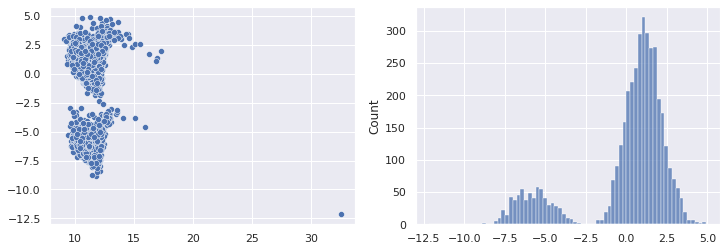

                            OLS Regression Results                            
Dep. Variable:             GDP_Scaled   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     106.5
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           1.97e-86
Time:                        14:13:48   Log-Likelihood:                -9946.1
No. Observations:                4089   AIC:                         1.990e+04
Df Residuals:                    4084   BIC:                         1.993e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.8482      0.421     16.255      

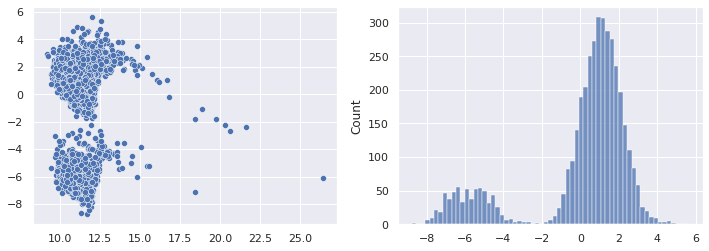

                            OLS Regression Results                            
Dep. Variable:             GDP_Scaled   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     109.4
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           1.12e-88
Time:                        14:13:49   Log-Likelihood:                -9940.9
No. Observations:                4089   AIC:                         1.989e+04
Df Residuals:                    4084   BIC:                         1.992e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7

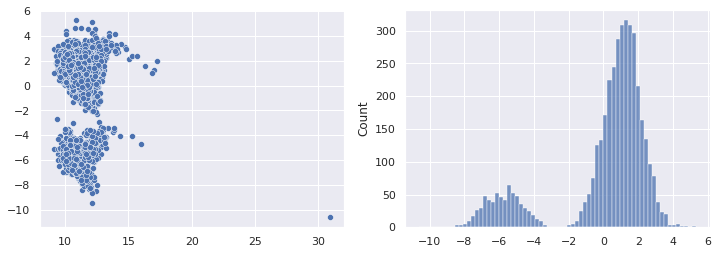

                            OLS Regression Results                            
Dep. Variable:             GDP_Scaled   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     95.97
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           7.33e-96
Time:                        14:13:49   Log-Likelihood:                -9921.8
No. Observations:                4089   AIC:                         1.986e+04
Df Residuals:                    4083   BIC:                         1.989e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7

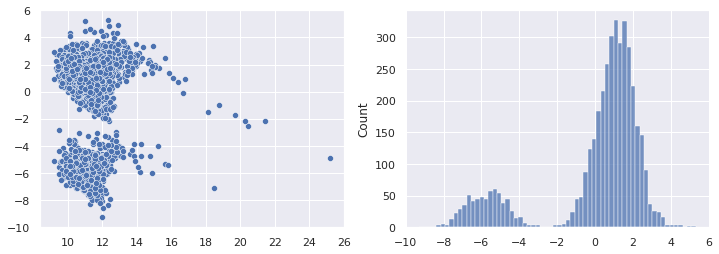

In [131]:
models=[]
for f in ['GDP_Scaled ~ IDHM+IBGE_WORK+URB',
         'GDP_Scaled ~ betweenness+IDHM+IBGE_WORK+URB',
         'GDP_Scaled ~ IDHM+clustering_coefficient+IBGE_WORK+URB',
         'GDP_Scaled ~ betweenness+IDHM+clustering_coefficient+IBGE_WORK+URB']: 
    model, result = make_model(df3, f)
    print(result.summary())
    linear_resplot(result)
    models.append([model,result])
             

In [133]:
df_subgroup_alpha = df3[models[-1][1].resid > -2.5]
df_subgroup_beta = df3[models[-1][1].resid <= -2.5]


In [134]:
df_subgroup_alpha.describe()

,id,IBGE_DU,IBGE_DU_URBAN,IBGE_POP,IBGE_WORK,IDHM,GDP,GDP_CAPITA,LAT,LONG,degree,betweenness,clustering_coefficient,URB,GDP_Scaled
count,3416.000000,3416.000000,3416.000000,3.416000e+03,3.416000e+03,3416.000000,3.416000e+03,3416.000000,3416.000000,3416.000000,3416.000000,3416.000000,3416.000000,3416.000000,3416.000000
mean,2041.371487,9859.162763,8348.534251,2.639267e+04,1.739373e+04,0.661862,1.029327e+06,21391.270918,-16.531013,-46.105057,0.005118,0.000404,0.630190,0.664726,12.367241
std,1182.354599,34804.581809,34494.482651,1.035546e+05,7.056756e+04,0.071396,5.681124e+06,20831.335543,8.180432,6.365191,0.008615,0.002442,0.300519,0.210803,1.376027
min,0.000000,239.000000,60.000000,1.740000e+02,9.400000e+01,0.418000,1.167483e+04,3190.570000,-33.687567,-72.916501,0.000000,0.000000,0.000000,0.060345,9.365191
25%,1020.750000,1778.000000,1009.500000,3.283000e+03,2.044750e+03,0.602000,9.065668e+04,9146.767500,-22.786800,-50.833614,0.000978,0.000000,0.445647,0.505141,11.414834
50%,2050.500000,3573.500000,2158.000000,7.160000e+03,4.457500e+03,0.670000,1.890081e+05,16115.710000,-18.299151,-46.417409,0.002446,0.000003,0.666667,0.678897,12.149544
75%,3055.250000,7174.750000,5058.000000,1.651350e+04,1.041075e+04,0.720000,4.750746e+05,26653.007500,-8.769592,-40.856450,0.005382,0.000090,0.893939,0.845667,13.071226
max,4088.000000,860309.000000,860090.000000,2.450634e+06,1.683918e+06,0.847000,2.354971e+08,314637.690000,4.475259,-34.813930,0.125000,0.075789,1.000000,1.000000,19.277209


In [135]:
df_subgroup_beta.describe()

,id,IBGE_DU,IBGE_DU_URBAN,IBGE_POP,IBGE_WORK,IDHM,GDP,GDP_CAPITA,LAT,LONG,degree,betweenness,clustering_coefficient,URB,GDP_Scaled
count,673.000000,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,673.000000,6.730000e+02,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000
mean,2057.341753,1.773985e+04,1.621514e+04,5.011756e+04,3.342311e+04,0.666514,1.111427e+06,22055.237429,-16.511457,-46.411274,0.005896,0.001035,0.635986,0.678485,5.576554
std,1172.050346,1.446894e+05,1.436662e+05,4.257642e+05,2.873964e+05,0.073502,2.658107e+07,18918.041827,8.358929,6.682977,0.014981,0.012769,0.299715,0.214023,1.674358
min,15.000000,3.870000e+02,1.300000e+02,3.170000e+02,1.940000e+02,0.471000,1.496000e+01,4689.380000,-31.412366,-69.563459,0.000000,0.000000,0.000000,0.124151,2.705380
25%,1030.000000,1.708000e+03,9.600000e+02,3.186000e+03,1.967000e+03,0.607000,7.640000e+01,9436.770000,-22.744771,-50.841623,0.000978,0.000000,0.436559,0.527253,4.335983
50%,2031.000000,3.555000e+03,2.065000e+03,6.879000e+03,4.344000e+03,0.672000,1.906500e+02,17139.040000,-19.168892,-46.996630,0.002446,0.000002,0.666667,0.707320,5.250439
75%,3110.000000,8.001000e+03,6.184000e+03,2.016400e+04,1.287900e+04,0.727000,6.716500e+02,28025.470000,-8.704689,-41.617959,0.005382,0.000095,0.910256,0.852713,6.509737
max,4072.000000,3.576148e+06,3.548433e+06,1.046364e+07,7.058221e+06,0.840000,6.870359e+08,180824.630000,3.350289,-34.884792,0.297945,0.323438,1.000000,1.000000,20.347897


                            OLS Regression Results                            
Dep. Variable:             GDP_Scaled   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     1021.
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:16:39   Log-Likelihood:                -4843.1
No. Observations:                3416   AIC:                             9694.
Df Residuals:                    3412   BIC:                             9719.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.9062      0.168     47.063      0.0

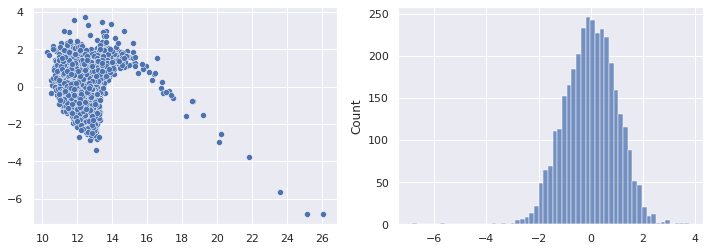

                            OLS Regression Results                            
Dep. Variable:             GDP_Scaled   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     778.0
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:16:39   Log-Likelihood:                -4829.6
No. Observations:                3416   AIC:                             9669.
Df Residuals:                    3411   BIC:                             9700.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.8858      0.167     47.108      

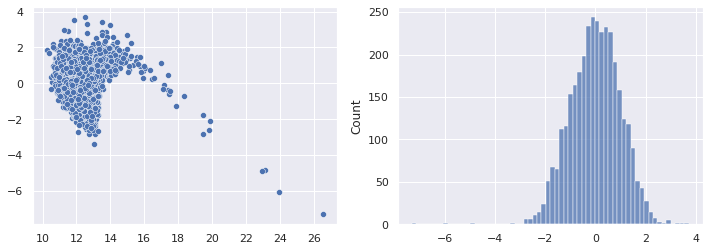

                            OLS Regression Results                            
Dep. Variable:             GDP_Scaled   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     840.4
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:16:40   Log-Likelihood:                -4765.5
No. Observations:                3416   AIC:                             9541.
Df Residuals:                    3411   BIC:                             9572.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  8

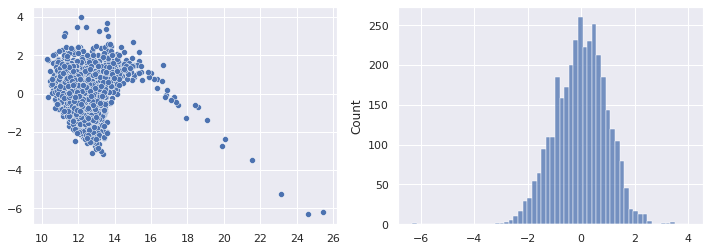

                            OLS Regression Results                            
Dep. Variable:             GDP_Scaled   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     686.5
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:16:41   Log-Likelihood:                -4747.5
No. Observations:                3416   AIC:                             9507.
Df Residuals:                    3410   BIC:                             9544.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  8

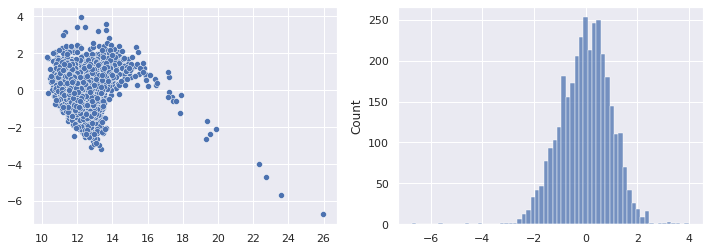

In [136]:
models_alpha=[]
for f in ['GDP_Scaled ~ IDHM+IBGE_WORK+URB',
         'GDP_Scaled ~ betweenness+IDHM+IBGE_WORK+URB',
         'GDP_Scaled ~ IDHM+clustering_coefficient+IBGE_WORK+URB',
         'GDP_Scaled ~ betweenness+IDHM+clustering_coefficient+IBGE_WORK+URB']: 
    model, result = make_model(df_subgroup_alpha, f)
    print(result.summary())
    linear_resplot(result)
    models_alpha.append([model,result])

                            OLS Regression Results                            
Dep. Variable:             GDP_Scaled   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     233.9
Date:                Mon, 08 Nov 2021   Prob (F-statistic):          9.47e-104
Time:                        14:18:33   Log-Likelihood:                -1060.0
No. Observations:                 673   AIC:                             2128.
Df Residuals:                     669   BIC:                             2146.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0307      0.441     -0.070      0.9

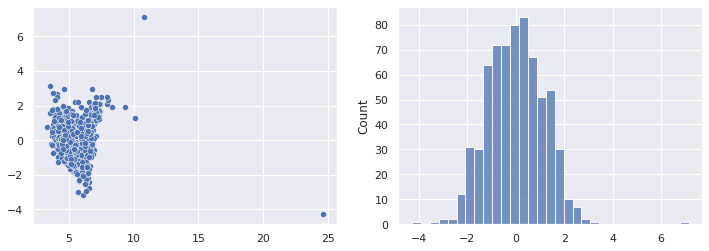

                            OLS Regression Results                            
Dep. Variable:             GDP_Scaled   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     233.6
Date:                Mon, 08 Nov 2021   Prob (F-statistic):          2.28e-125
Time:                        14:18:35   Log-Likelihood:                -1006.9
No. Observations:                 673   AIC:                             2024.
Df Residuals:                     668   BIC:                             2046.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.4557      0.410      1.112      

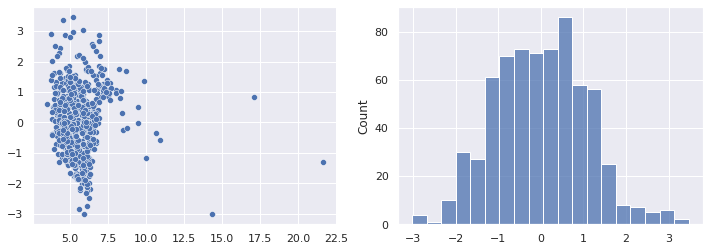

                            OLS Regression Results                            
Dep. Variable:             GDP_Scaled   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     207.7
Date:                Mon, 08 Nov 2021   Prob (F-statistic):          1.12e-115
Time:                        14:18:35   Log-Likelihood:                -1029.4
No. Observations:                 673   AIC:                             2069.
Df Residuals:                     668   BIC:                             2091.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

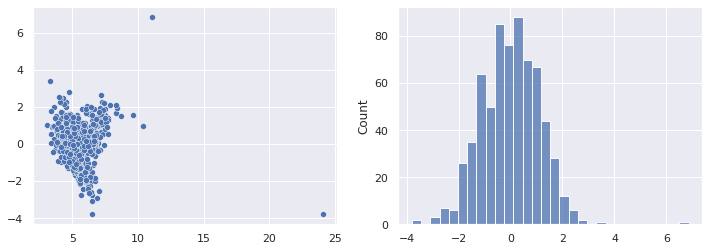

                            OLS Regression Results                            
Dep. Variable:             GDP_Scaled   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     215.5
Date:                Mon, 08 Nov 2021   Prob (F-statistic):          1.22e-136
Time:                        14:18:36   Log-Likelihood:                -977.77
No. Observations:                 673   AIC:                             1968.
Df Residuals:                     667   BIC:                             1995.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

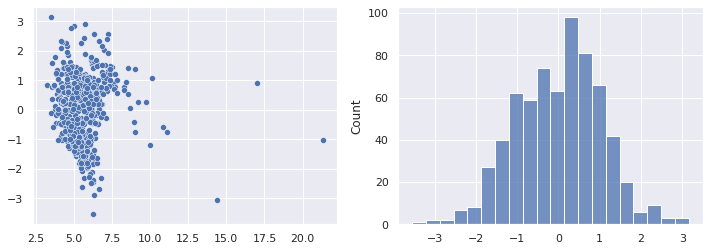

In [138]:
models_beta=[]
for f in ['GDP_Scaled ~ IDHM+IBGE_WORK+URB',
         'GDP_Scaled ~ betweenness+IDHM+IBGE_WORK+URB',
         'GDP_Scaled ~ IDHM+clustering_coefficient+IBGE_WORK+URB',
         'GDP_Scaled ~ betweenness+IDHM+clustering_coefficient+IBGE_WORK+URB']: 
    model, result = make_model(df_subgroup_beta, f)
    print(result.summary())
    linear_resplot(result)
    models_beta.append([model,result])

In [139]:
df_subgroup_alpha

,id,CITY_STATE,IBGE_DU,IBGE_DU_URBAN,IBGE_POP,IBGE_WORK,IDHM,GDP,GDP_CAPITA,LAT,LONG,degree,betweenness,clustering_coefficient,URB,GDP_Scaled
0,0,Abadiânia - GO,4655.0,3233.0,10656.0,6896.0,0.690,287984.49,15628.40,-16.182672,-48.718812,0.001223,1.312806e-07,0.700000,0.694522,12.570662
1,1,Abaeté - MG,7694.0,6667.0,18464.0,11979.0,0.698,430235.36,18250.42,-19.155848,-45.446191,0.004403,2.365389e-04,0.562092,0.866519,12.972088
2,2,Abaetetuba - PA,31061.0,19057.0,82956.0,53516.0,0.628,1249255.29,8222.36,-1.723470,-48.884404,0.002691,1.659611e-06,0.472727,0.613535,14.038058
3,3,Abaiara - CE,2791.0,1251.0,4538.0,2631.0,0.628,73151.46,6370.41,-7.356977,-39.047547,0.000734,0.000000e+00,1.000000,0.448226,11.200287
4,4,Abaíra - BA,2572.0,1193.0,3725.0,2319.0,0.603,64324.59,6982.70,-13.253532,-41.661608,0.004892,2.447182e-05,0.452632,0.463841,11.071697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4084,4084,Xique-Xique - BA,11637.0,8461.0,32497.0,19371.0,0.585,342261.06,7089.97,-10.824974,-42.725508,0.008072,7.552095e-05,0.467803,0.727077,12.743329
4085,4085,Zabelê - PB,673.0,489.0,1469.0,874.0,0.623,19582.06,8793.02,-8.076874,-37.093552,0.001223,0.000000e+00,1.000000,0.726597,9.882369
4086,4086,Zacarias - SP,799.0,638.0,1836.0,1165.0,0.730,75934.89,29149.67,-21.050110,-50.055740,0.000734,0.000000e+00,1.000000,0.798498,11.237632
4087,4087,Zé Doca - MA,11886.0,7611.0,30803.0,18136.0,0.595,380509.30,7489.46,-3.275481,-45.657698,0.010763,9.153418e-05,0.535941,0.640333,12.849266


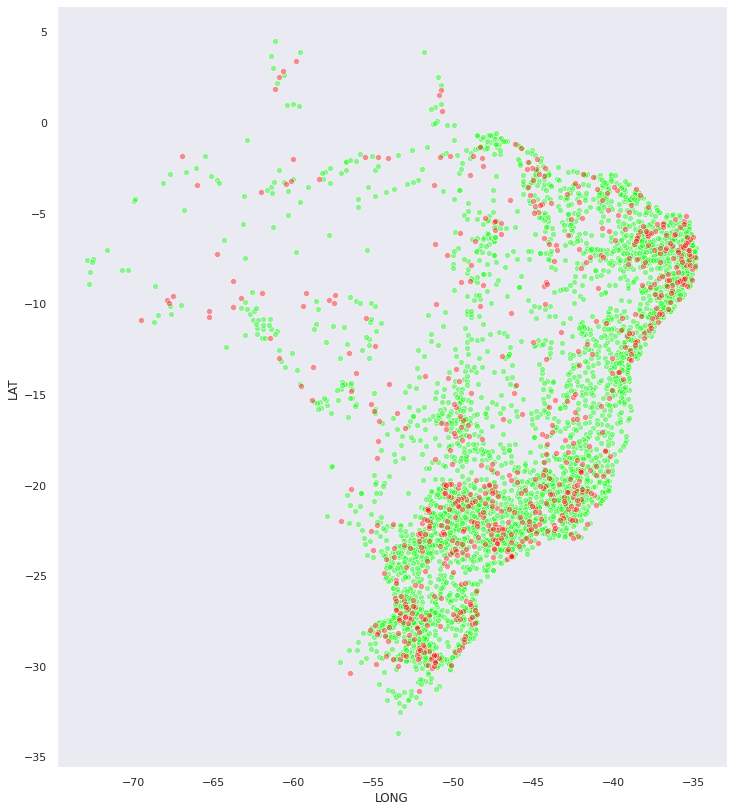

In [140]:
plt.figure(figsize=(12,14))
sns.scatterplot(x=df_subgroup_alpha["LONG"], y=df_subgroup_alpha["LAT"], color=[[0,1,0,0.4]])
sns.scatterplot(x=df_subgroup_beta["LONG"], y=df_subgroup_beta["LAT"], color=[[1,0,0,0.4]])
plt.grid(False)
plt.savefig("spatial.png")
plt.show()


In [141]:
# AVG % Diff between categories
df_subgroup_beta.describe().loc["mean"]/df_subgroup_alpha.describe().loc["mean"]

id                        1.007823
IBGE_DU                   1.799327
IBGE_DU_URBAN             1.942274
IBGE_POP                  1.898920
IBGE_WORK                 1.921560
IDHM                      1.007029
GDP                       1.079761
GDP_CAPITA                1.031039
LAT                       0.998817
LONG                      1.006642
degree                    1.152004
betweenness               2.562745
clustering_coefficient    1.009198
URB                       1.020698
GDP_Scaled                0.450913
Name: mean, dtype: float64

In [142]:
def plot_hist_col(col_name):
    plt.figure(figsize=(7,7))
    sns.histplot(df_subgroup_alpha[col_name].apply(np.log))
    sns.histplot(df_subgroup_beta[col_name].apply(np.log),color=[[0,1,0]])
    plt.show()

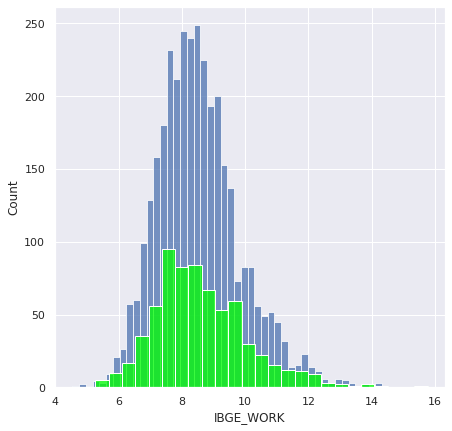

In [106]:
# plot_hist_col("IBGE_WORK")
# plot_hist_col("betweenness")
# plot_hist_col("GDP")
# plot_hist_col("IBGE_POP")
# plot_hist_col("IBGE_DU")
# plot_hist_col("IBGE_DU_URBAN")
# plot_hist_col("IDHM")

In [178]:
from statsmodels.stats.weightstats import ttest_ind

def t_test(col_name):
#     t, p, _ = ttest_ind(df_subgroup_alpha[col_name], df_subgroup_beta[col_name])
#     print(f"Coluna {col_name} tem teste-t = (t,p) {t:.03f}, {p:.03f}")
          
    t, p, _ = ttest_ind(df_subgroup_alpha[col_name].apply(np.log), df_subgroup_beta[col_name].apply(np.log))
    if not np.isnan(t):
        print(f"Coluna {col_name} tem teste-t (log) = (t,p) {t:.03f}, {p:.03f}")

In [179]:
for i in ["IBGE_WORK", "betweenness", "GDP", "IBGE_POP", "IBGE_DU", "IBGE_DU_URBAN", "IDHM", "clustering_coefficient"]:
    t_test(i)

Coluna IBGE_WORK tem teste-t (log) = (t,p) -1.090, 0.276
Coluna GDP tem teste-t (log) = (t,p) 112.649, 0.000
Coluna IBGE_POP tem teste-t (log) = (t,p) -1.053, 0.292
Coluna IBGE_DU tem teste-t (log) = (t,p) -0.954, 0.340
Coluna IBGE_DU_URBAN tem teste-t (log) = (t,p) -1.173, 0.241
Coluna IDHM tem teste-t (log) = (t,p) -1.443, 0.149
